### Here we study the photometry noise based on the GAMA catalog

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
import torch
import corner
import os

In [3]:
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')

In [4]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.utils import flux2mag, mag2flux, sigma_flux2mag, sigma_mag2flux

In [5]:
gama_cat = Table.read('./reference_catalog/GAMA/gama_spec_photometry.fits')

In [38]:
filters = list('ugrizYJHK')

In [12]:
mags = np.vstack([gama_cat[col].data for col in [f'MAG_AUTO_{filt}' for filt in list('ugrizYJHK')]]).T
mags_err = np.vstack([gama_cat[col].data for col in [f'MAGERR_AUTO_{filt}' for filt in list('ugrizYJHK')]]).T

In [13]:
flag = np.all((mags != 99.0), axis=1) & np.all((mags != -9999.0), axis=1) & np.all((mags != -99.0), axis=1) 
flag &= (mags[:, 2] < 19.65) & ((mags[:, 6] - mags[:, 8]) > 0.025)

In [14]:
np.sum(flag)

125068

In [15]:
mags = mags[flag]
sigs = mags_err[flag] # sigma of magnitude

In [41]:
np.save('./reference_catalog/GAMA/gama_clean_mag.npy', mags)

In [17]:
np.min(sigs)

0.00016210804

In [18]:
flux = mag2flux(mags)
ivar = sigma_mag2flux(sigs, mags)
snrs = flux / ivar

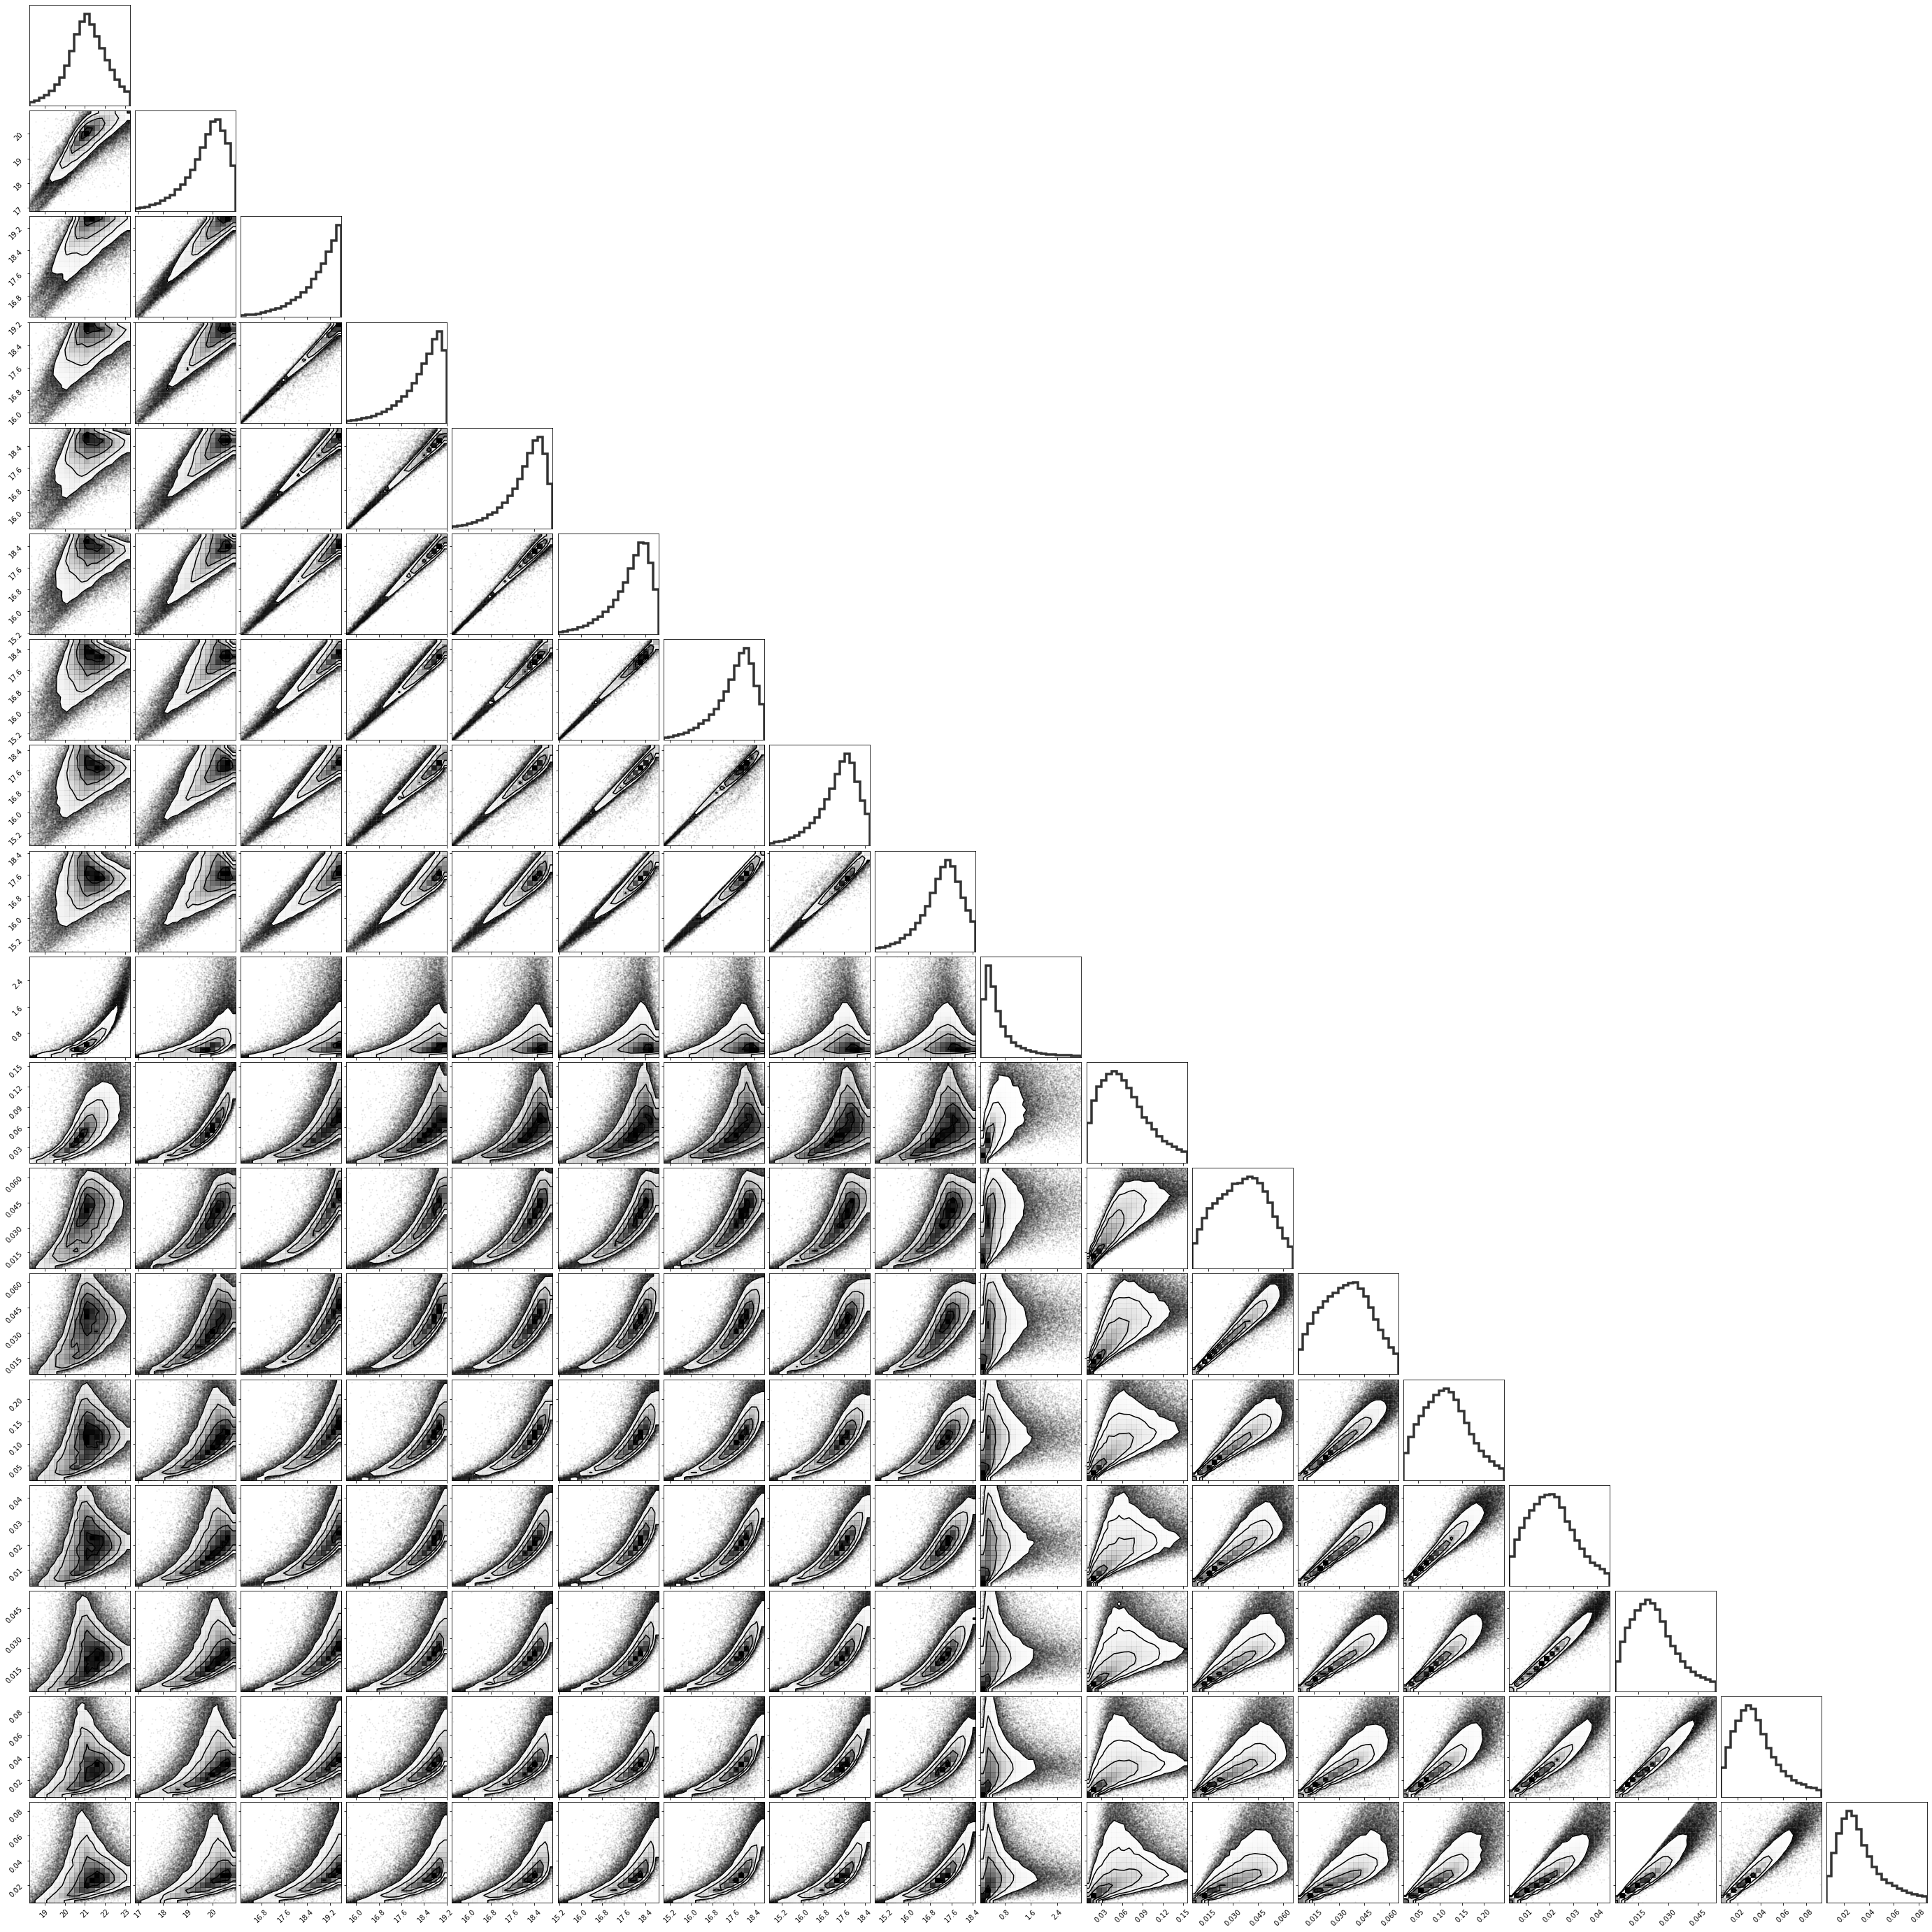

In [19]:
fig = corner.corner(np.concatenate([mags, sigs], axis=1), 
                    range=np.nanquantile(
                     np.concatenate([mags, sigs], axis=1), 
                     [0.01, 0.95], axis=0).T)

In [22]:
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d

In [32]:
def trimmed_median(x): 
    xlim = np.quantile(x, [0.0, 0.95])
    return np.median(x[(x > xlim[0]) & (x < xlim[1])])

def trimmed_std(x): 
    xlim = np.quantile(x, [0.0, 0.95])
    return np.std(x[(x > xlim[0]) & (x < xlim[1])])

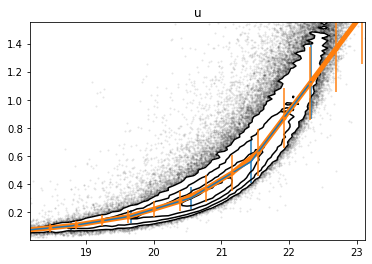

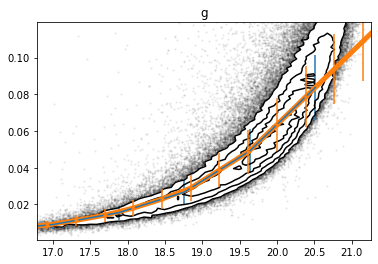

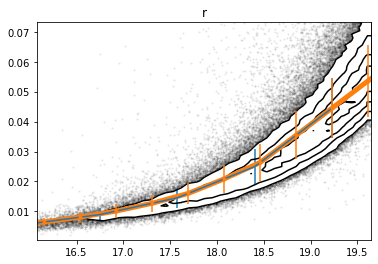

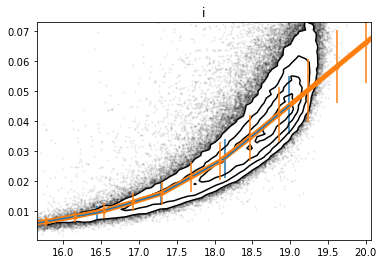

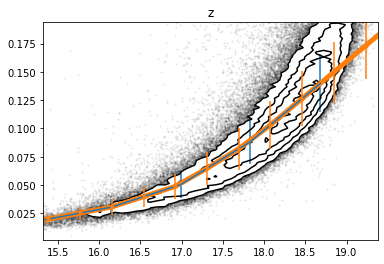

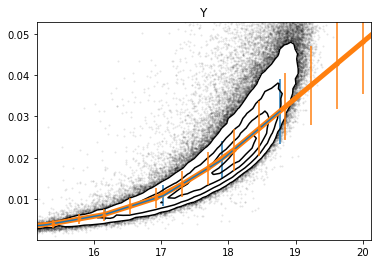

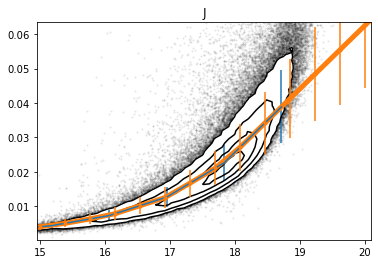

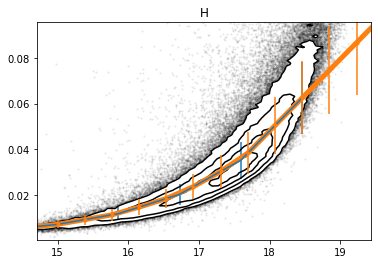

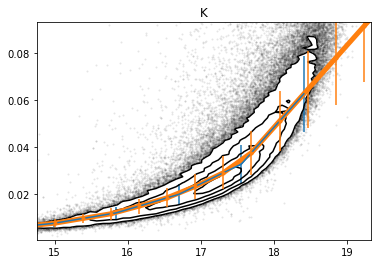

In [39]:
meds_sigs, stds_sigs = [], [] 

for i in range(len(filters)): 
    clean = (np.isfinite(mags[:,i]) & (sigs[:,i] < np.max([np.quantile(sigs[:,i], 0.9), 0.12])))

    med_sig, mags_edges, _ = binned_statistic(mags[clean,i], sigs[clean,i], statistic=trimmed_median, 
                                              range=np.nanquantile(mags[clean,i], [0., 0.995]), bins=10)
    std_sig, mags_edges, _ = binned_statistic(mags[clean,i], sigs[clean,i], statistic=trimmed_std, 
                                              range=np.nanquantile(mags[clean,i], [0., 0.995]), bins=10)
    
    finite = (np.isfinite(med_sig) & np.isfinite(std_sig))
    meds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], med_sig[finite], 
                              fill_value='extrapolate'))
    stds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], std_sig[finite], 
                              fill_value='extrapolate'))
    
    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    sub.plot(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig, c='C0')
    sub.errorbar(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig,
                 yerr=std_sig, c='C0')
    corner.hist2d(mags[clean,i], sigs[clean,i], plot_density=False, bins=100, ax=sub)
    
    sub.plot(np.linspace(10, 25, 40), meds_sigs[-1](np.linspace(10, 25, 40)), c='C1', lw=5)
    sub.errorbar(np.linspace(10, 25, 40), meds_sigs[-1](np.linspace(10, 25, 40)), 
                 yerr=stds_sigs[-1](np.linspace(10, 25, 40)), fmt='.C1')
    sub.set_xlim(np.nanquantile(mags[clean,i], [0.01, 1.]))
    sub.set_ylim(np.nanquantile(sigs[clean,i], [0.0, 0.975]))
    
    sub.set_title(filters[i])

In [40]:
np.save('./noise_model/gama_noise_model_mag.npy', np.vstack([meds_sigs, stds_sigs]))